# Digit Recognizer

### Import Dependencies

In [17]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
%matplotlib inline

import csv

In [18]:
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth=True
# config.gpu_options.per_process_gpu_memory_fraction = 0.3
# sess = tf.Session(config=config)

### Preparing Data

In [19]:
data = pd.read_csv('train.csv')
train, dev = train_test_split(data, test_size=0.2,random_state=0, stratify=data['label'])
print(train.shape, dev.shape)

(33600, 785) (8400, 785)


In [20]:
Y_train = train.iloc[:, 0].as_matrix()
Y_train = np.eye(10, dtype='float32')[Y_train] 
#it's imp to specify dtype, as default is float64, but placeholder expects float32.
X_train = train.iloc[:,1:].as_matrix().astype('float32')

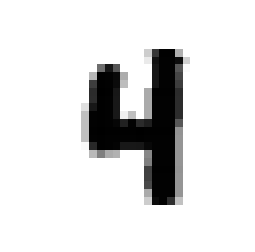

In [21]:
index = 1057
img = X_train[index].reshape(28, 28)
plt.axis('off')
plt.imshow(img, cmap=cm.binary)

In [22]:
Y_dev = dev.iloc[:, 0].as_matrix()
Y_dev = np.eye(10, dtype='float32')[Y_dev]
X_dev = dev.iloc[:,1:].as_matrix().astype('float32')

In [23]:
X_test = pd.read_csv('test.csv').as_matrix().astype('float32')
X_test = np.multiply(X_test, 1.0/255.0)

In [24]:
X_train = np.multiply(X_train, 1.0/255.0)
X_dev = np.multiply(X_dev, 1.0/255.0)

In [25]:
print(X_train.shape, Y_train.shape)
print(X_dev.shape, Y_dev.shape)
print(X_test.shape)

(33600, 784) (33600, 10)
(8400, 784) (8400, 10)
(28000, 784)


In [26]:
def get_next_batch(initial, batch_size, X, Y):
    i = initial * batch_size
    j = i + batch_size
    return X[i:j], Y[i:j]

### Build Computation Graph

#### CNN implementation

In [27]:
def create_placholders():
    X = tf.placeholder(tf.float32, [None, 784], name='X')
    Y = tf.placeholder(tf.int32, [None, 10], name='Y')
    return (X, Y)

In [28]:
def initialize_parameters():
    W1 = tf.get_variable('W1', [5, 5, 1, 32], initializer= tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable('W2', [5, 5, 32, 64], initializer= tf.contrib.layers.xavier_initializer(seed=0))
    return (W1, W2)

In [29]:
def forward_propogation(X, parameters):
    W1, W2 = parameters
    X = tf.reshape(X, [-1, 28, 28, 1])

    Z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding='SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    Z2 = tf.nn.conv2d(P1, W2, strides=[1,1,1,1], padding='SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    P2 = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(P2, num_outputs=1024)
    
    Z4 = tf.contrib.layers.fully_connected(Z3, num_outputs=10, activation_fn=None)
    
    return Z4

In [30]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y), name='cost')
    return cost

In [31]:
def model(X_train, Y_train, X_dev, Y_dev, X_test, learning_rate, num_epochs, 
                                                      minibatch_size):
    X, Y = create_placholders()
    parameters = initialize_parameters()
    Z3 = forward_propogation(X, parameters)
    cost = compute_cost(Z3, Y)
    adam_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Z3, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    m = X_train.shape[0]
    costs = []
    num_minibatches = m // minibatch_size
    with tf.Session(config=config) as sess:
        sess.run(init)        
        for epoch in range(num_epochs):
            epoch_cost = 0 
            for initial in range(num_minibatches):
                batch_xs, batch_ys = get_next_batch(initial, minibatch_size, X_train, Y_train)
                _, c = sess.run([adam_optimizer, cost], feed_dict={X: batch_xs, Y: batch_ys})
                epoch_cost += c
            epoch_cost /= num_minibatches
            costs.append(epoch_cost)
            print('Epoch:', epoch, 'Cost', epoch_cost)

        plt.plot(np.squeeze(costs))
        plt.show()

        acc = 0
        for initial in range(num_minibatches):
            batch_xs, batch_ys = get_next_batch(initial, minibatch_size, X_train, Y_train)
            acc += sess.run(accuracy, feed_dict={X:batch_xs, Y:batch_ys})

        train_accuracy = acc/num_minibatches
        dev_accuracy = sess.run(accuracy, feed_dict={X:X_dev, Y:Y_dev})
        
        print('Train set accuracy', train_accuracy)
        print('Dev set accuracy', dev_accuracy)
        
        m = X_test.shape[0]
        Y_predicted = np.random.randn(m,1)
        for k in range(0, m//1000):
            i = k*1000
            j = i+1000
            Y_predicted[i:j, 0] = sess.run(tf.argmax(Z3, 1), feed_dict = {X: X_test[i:j]})

    return np.squeeze(Y_predicted).astype('int')

### Train and Test the model

Epoch: 0 Cost 1.05360341682
Epoch: 1 Cost 0.0886662926412
Epoch: 2 Cost 0.0470755032518
Epoch: 3 Cost 0.0343144298672
Epoch: 4 Cost 0.0271825199721
Epoch: 5 Cost 0.0226679926061
Epoch: 6 Cost 0.0244578029678
Epoch: 7 Cost 0.0200566619098
Epoch: 8 Cost 0.013358564617
Epoch: 9 Cost 0.014326796359
Epoch: 10 Cost 0.014378961599
Epoch: 11 Cost 0.00840109034978
Epoch: 12 Cost 0.00451309005659
Epoch: 13 Cost 0.00305803841999


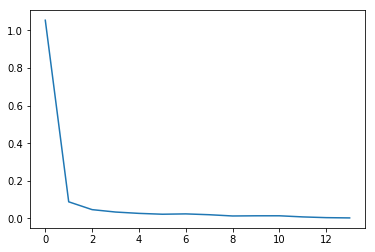

Train set accuracy 0.999454550671
Dev set accuracy 0.988214
CPU times: user 31.4 s, sys: 5.74 s, total: 37.1 s
Wall time: 56.4 s


In [45]:
%%time
tf.reset_default_graph()
learning_rate = 0.01
minibatch_size = 1000
num_epochs = 14
Y_predicted = model(X_train, Y_train, X_dev, Y_dev, X_test, learning_rate, num_epochs, minibatch_size)

### Prediction on kaggle dev data set

In [44]:
with open('submission-cnn.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerow(['ImageId', 'Label'])
    for i in range(Y_predicted.shape[0]):
        writer.writerow([i+1, Y_predicted[i]])

#### For tensorboard visualization

In [34]:
# writer = tf.summary.FileWriter("output", sess.graph)
# writer.close()

In [35]:
#before changing any node in the graph, reset the default graph, run new nodes, reinitialize the session and variables.
# to retrain the model, just re-initialise the variables by sess.run(init)
# sess.close ? what it actually does?
# none of this releases gpu memory
# sess.close()
# tf.reset_default_graph() # new default graph is created. 
#parameters contains only W1 and W2.
#not other parameters like FC weights and biases

In [36]:
# with tf.Session() as sess:
#     print(sess.run(tf.report_uninitialized_variables()))